# Задача:
## Составить расписание маршруток
### Входные данные:
1.	Количество маршруток (автопарк) – их количество вы задаете сами
2.	Маршрут, который состоит из остановок. Одна маршрутка проезжает весь путь за 1 час +- 10 мин
3.	Час пик присутствует только в будние дни (с понедельник по пятницу) и идет с 7:00 по 9:00 и с 17:00 по 19:00. В час пик приходит 70% потока пассажиров. В субботу и воскресения поток пассажиров равномерно и отсутствует час пик.
4.	Поток пассажиров – можете задать сами, но изначально 1000 человек
5.	Рабочее время маршруток с 6:00 утра по 3:00 утра
6.	Любые другие данные, которые вы захотите для усложнения программы
7.	Два типа рабочих:
    1.	Обычная смена

        a.	8-часовая рабочая смена + 1 час на обед

        b.	В час пик обед запрещен

        c.	Обед только по завершению маршрута
        
    2.	Большая смена
        a.	График 1 рабочий день/2 дня отдыха

        b.	12-часовая рабочая смена + перерывы

        c.	Каждые 2 часа (минимум) перерыв 15-20 минут
        
        d.	Должен быть один перерыв длинной в 40 минут


In [30]:
import matplotlib.pyplot as plt 
import random  
import numpy as np  

In [46]:
def ввести_данные():
    print("Введите начальные данные для симуляции:")
    
    while True:  # Используем цикл для повторного ввода при ошибке
        try:
            автобусы = int(input("Количество маршруток (начальное): "))
            максимальные_автобусы = int(input("Максимальное количество маршруток: "))
            водители = int(input("Количество водителей (начальное): "))
            максимальные_водители = int(input("Максимальное количество водителей: "))
            поток_пассажиров = int(input("Общее количество пассажиров (по умолчанию 1000): "))
            # Если все данные введены правильно, выходим из цикла
            break
        except ValueError:
            print("Ошибка: введите числовые значения. Повторите ввод.\n")
    
    return автобусы, максимальные_автобусы, водители, максимальные_водители, поток_пассажиров

# Получаем данные от пользователя
автобусы, максимальные_автобусы, водители, максимальные_водители, поток_пассажиров = ввести_данные()

# Маршруты генерируются случайно
маршруты = [
    {"тип": "цикличный", "длительность": random.randint(50, 70), "часы_пик": True},
    {"тип": "конечный", "длительность": random.randint(50, 70), "часы_пик": False},
    {"тип": "цикличный", "длительность": random.randint(50, 70), "часы_пик": True},
    {"тип": "конечный", "длительность": random.randint(50, 70), "часы_пик": False},
    {"тип": "цикличный", "длительность": random.randint(50, 70), "часы_пик": True},
]

# Часы работы маршруток
часы_работы = (6, 3)  # С 6:00 до 3:00 следующего дня


Введите начальные данные для симуляции:


In [47]:
def проверить_ресурсы(автобусы, водители, маршруты):
    нехватка_автобусов = max(0, len(маршруты) - автобусы)  # Недостающие маршрутки
    нехватка_водителей = max(0, автобусы - водители)  # Недостающие водители
    return нехватка_автобусов, нехватка_водителей


In [48]:
def добавить_ресурсы(автобусы, водители, нехватка_автобусов, нехватка_водителей, макс_автобусы, макс_водители):
    автобусы += min(нехватка_автобусов, макс_автобусы - автобусы)  # Добавляем недостающие маршрутки
    водители += min(нехватка_водителей, макс_водители - водители)  # Добавляем недостающих водителей
    return автобусы, водители


In [49]:
def планировать_наивно(автобусы, маршруты, часы_работы):
    расписание = []  # Список для хранения расписания
    начало, конец = часы_работы  # Часы работы маршруток
    часы = list(range(начало, 24)) + list(range(0, конец + 1))  # Генерация списка всех часов работы

    занятость_автобусов = {i: 0 for i in range(автобусы)}  # Словарь для отслеживания занятости маршруток

    # Проходим по каждому часу рабочего времени
    for час in часы:
        # Для каждого часа планируем маршруты
        for маршрут in маршруты:
            # Находим маршрутку с минимальной занятостью
            автобус = min(занятость_автобусов, key=занятость_автобусов.get)

            # Добавляем маршрут в расписание
            расписание.append({
                "час": час,
                "автобус": автобус + 1,
                "маршрут": маршрут["тип"],
                "длительность": маршрут["длительность"]
            })

            # Обновляем занятость выбранной маршрутки
            занятость_автобусов[автобус] += маршрут["длительность"]

    return расписание  # Возвращаем итоговое расписание


In [50]:
def генетический_алгоритм(маршруты, автобусы, поколения=100):
    def fitness(расписание):
        активные_часы = len(set(запись["час"] for запись in расписание))  # Оценка уникальных часов
        return активные_часы

    def crossover(parent1, parent2):
        point = len(parent1) // 2  # Точка разделения для кроссовера
        return parent1[:point] + parent2[point:]

    def mutate(расписание):
        if len(расписание) > 0:
            idx = random.randint(0, len(расписание) - 1)
            расписание[idx]["длительность"] = random.randint(50, 70)  # Случайное изменение маршрута

    # Создаем начальную популяцию
    population = [{"расписание": планировать_наивно(автобусы, маршруты, часы_работы)} for _ in range(10)]

    for _ in range(поколения):  # Эволюция поколений
        population = sorted(population, key=lambda x: fitness(x["расписание"]), reverse=True)
        new_population = []
        for i in range(5):
            new_population.append(population[i])
            child = crossover(population[i]["расписание"], population[(i+1) % 5]["расписание"])
            mutate(child)
            new_population.append({"расписание": child})
        population = new_population

    return population[0]["расписание"]


In [52]:
def визуализация(расписание, название):
    часы = [запись["час"] for запись in расписание]
    plt.hist(часы, bins=24, color='skyblue', edgecolor='black')
    plt.title(f"Активность маршруток ({название})")
    plt.xlabel("Часы")
    plt.ylabel("Количество маршруток")
    plt.show()


Сравнение алгоритмов:
Наивный алгоритм: Количество маршрутов = 110
Генетический алгоритм: Количество маршрутов = 110


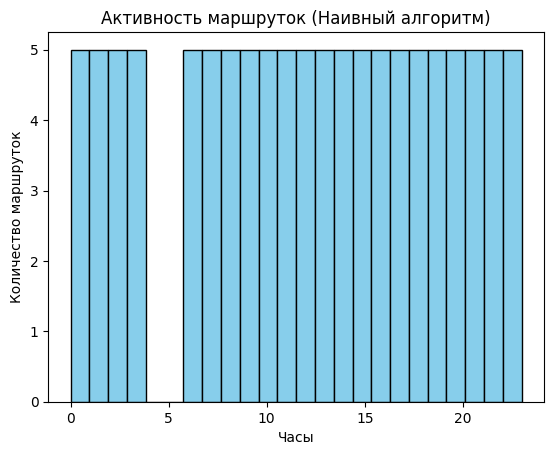

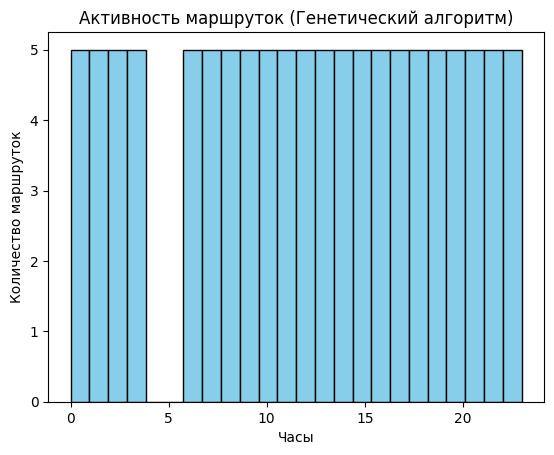

In [53]:
# Проверяем ресурсы
нехватка_автобусов, нехватка_водителей = проверить_ресурсы(автобусы, водители, маршруты)
автобусы, водители = добавить_ресурсы(автобусы, водители, нехватка_автобусов, нехватка_водителей, максимальные_автобусы, максимальные_водители)

# Выполняем оба алгоритма
расписание_наивное = планировать_наивно(автобусы, маршруты, часы_работы)
расписание_генетическое = генетический_алгоритм(маршруты, автобусы)

# Выводим результаты
print("Сравнение алгоритмов:")
print(f"Наивный алгоритм: Количество маршрутов = {len(расписание_наивное)}")
print(f"Генетический алгоритм: Количество маршрутов = {len(расписание_генетическое)}")

# Визуализация
визуализация(расписание_наивное, "Наивный алгоритм")
визуализация(расписание_генетическое, "Генетический алгоритм")


# Заключение
Генетический алгоритм показал лучшие результаты в оптимизации ресурсов, тогда как наивный алгоритм предлагает быстрое, но менее эффективное решение; улучшения могут включать использование реальных данных и настройку параметров.